## **Check Video Validity**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/ECHO_NET_DYNAMIC/Videos.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Videos/0X4C26D3921A0BB05C.avi  
  inflating: /content/Videos/0X4C28BDBE546E6B12.avi  
  inflating: /content/Videos/0X4C340319107C4943.avi  
  inflating: /content/Videos/0X4C371F553F658F4A.avi  
  inflating: /content/Videos/0X4C3886781B19B953.avi  
  inflating: /content/Videos/0X4C3D1288ECBB8117.avi  
  inflating: /content/Videos/0X4C3FFA0312ADF0DA.avi  
  inflating: /content/Videos/0X4C4591D9CB3DDDE8.avi  
  inflating: /content/Videos/0X4C4655AD4584F866.avi  
  inflating: /content/Videos/0X4C468BD8DD069AA8.avi  
  inflating: /content/Videos/0X4C49B523268655BE.avi  
  inflating: /content/Videos/0X4C4AB1371DF72873.avi  
  inflating: /content/Videos/0X4C4D6F2D3455F022.avi  
  inflating: /content/Videos/0X4C52576367EDE50B.avi  
  inflating: /content/Videos/0X4C53CDD47193BEC7.avi  
  inflating: /content/Videos/0X4C568666D11BB71.avi  
  inflating: /content/Videos/0X4C576D3B38DCAF3B.avi  
  inflating: /content/Videos/0X4

In [3]:
!cp "/content/drive/MyDrive/ECHO_NET_DYNAMIC/FileList.csv" "/content/"

In [4]:
!cp -r "/content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints" "/content/"


## **TEST DATA**

In [ ]:
import cv2
import os

video_dir = "/content/Videos"

valid_videos = []
corrupted_videos = []

for file in os.listdir(video_dir):
    if file.endswith(".avi"):
        path = os.path.join(video_dir, file)
        cap = cv2.VideoCapture(path)

        ret, frame = cap.read()

        if not ret:
            corrupted_videos.append(file)
        else:
            valid_videos.append(file)

        cap.release()

print("======================================")
print(f"Total videos found: {len(valid_videos) + len(corrupted_videos)}")
print(f"Valid videos: {len(valid_videos)}")
print(f"Corrupted videos: {len(corrupted_videos)}")
print("======================================")

print("Sample corrupted videos:", corrupted_videos[:20])


Total videos found: 10030
Valid videos: 10030
Corrupted videos: 0
Sample corrupted videos: []


In [ ]:
import cv2
import os

video_dir = "/content/Videos"

valid_videos = []
corrupted_videos = []

for file in os.listdir(video_dir):
    if file.endswith(".avi"):
        path = os.path.join(video_dir, file)
        cap = cv2.VideoCapture(path)

        ret, frame = cap.read()

        if not ret:
            corrupted_videos.append(file)
        else:
            valid_videos.append(file)

        cap.release()

print("======================================")
print(f"Total videos: {len(valid_videos) + len(corrupted_videos)}")
print(f"Valid videos (first frame read): {len(valid_videos)}")
print(f"Corrupted videos (failed to read first frame): {len(corrupted_videos)}")
print("======================================")

print("Sample corrupted videos:", corrupted_videos[:20])


Total videos: 10030
Valid videos (first frame read): 10030
Corrupted videos (failed to read first frame): 0
Sample corrupted videos: []


## **Train on sample of Data**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import random
from tqdm import tqdm

class EchoDatasetQuick(Dataset):
    def __init__(self, csv_path, video_dir, split='TRAIN', transform=None, max_videos=10):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['Split'] == split].head(max_videos)  # أول 10 فيديوهات فقط
        self.video_dir = video_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = os.path.join(self.video_dir, f"{row['FileName']}.avi")

        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            cap.release()
            random_ef = random.uniform(20, 70)
            return torch.zeros(3, 20, 112, 112), torch.tensor([random_ef])

        indices = np.linspace(0, total_frames-1, 20, dtype=int)

        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                cap.release()
                random_ef = random.uniform(20, 70)
                return torch.zeros(3, 20, 112, 112), torch.tensor([random_ef])
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()
        video = np.stack(frames).transpose(3, 0, 1, 2) / 255.0
        ef = row['EF']
        return torch.FloatTensor(video), torch.FloatTensor([ef])

class EFNetQuick(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv3d(3, 8, kernel_size=(3,3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2)),
            nn.Conv3d(8, 16, kernel_size=(3,3,3), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 4, 4))
        )
        self.lstm = nn.LSTM(input_size=16*4*4, hidden_size=32, num_layers=1, batch_first=True)
        self.regressor = nn.Linear(32, 1)

    def forward(self, x):
        batch_size = x.size(0)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1, 3, 4)
        cnn_out = cnn_out.reshape(batch_size, -1, 16*4*4)
        lstm_out, _ = self.lstm(cnn_out)
        return self.regressor(lstm_out[:, -1, :]).squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = EchoDatasetQuick('/content/FileList.csv', '/content/Videos', split='TRAIN', max_videos=10)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

model = EFNetQuick().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(2):  
    model.train()
    for videos, efs in loader:
        videos, efs = videos.to(device), efs.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, efs)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 2062.4414
Epoch 1, Loss: 2835.5122
Epoch 1, Loss: 3144.4346
Epoch 1, Loss: 4000.7449
Epoch 1, Loss: 3066.2559
Epoch 2, Loss: 3570.1274
Epoch 2, Loss: 2061.1819
Epoch 2, Loss: 1758.1738
Epoch 2, Loss: 4141.1074
Epoch 2, Loss: 3572.6245


## **Train on All Dataset**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
import glob
import re 

class EchoDataset(Dataset):
    def __init__(self, csv_path, video_dir, split='TRAIN', transform=None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['Split'] == split]
        self.video_dir = video_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = os.path.join(self.video_dir, f"{row['FileName']}.avi")

        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            cap.release()
            random_ef = random.uniform(20, 70)
            return torch.zeros(3, 20, 112, 112), torch.tensor([random_ef])

        indices = np.linspace(0, total_frames-1, 20, dtype=int)

        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                cap.release()
                random_ef = random.uniform(20, 70)
                return torch.zeros(3, 20, 112, 112), torch.tensor([random_ef])
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()
        video = np.stack(frames).transpose(3, 0, 1, 2) / 255.0
        ef = row['EF']
        return torch.FloatTensor(video), torch.FloatTensor([ef])

class EFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2)),

            nn.Conv3d(16, 32, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2)),

            nn.Conv3d(32, 64, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 4, 4))
        )

        self.lstm = nn.LSTM(input_size=64*4*4, hidden_size=128, num_layers=2, batch_first=True)

        self.regressor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1, 3, 4)
        cnn_out = cnn_out.reshape(batch_size, -1, 64*4*4)

        lstm_out, _ = self.lstm(cnn_out)
        last_frame_out = lstm_out[:, -1, :]

        ef_pred = self.regressor(last_frame_out)
        return ef_pred.squeeze()

def train_model(csv_path, video_dir, num_epochs=50, batch_size=4, resume_from_checkpoint=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive_folder = '/content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints'
    os.makedirs(drive_folder, exist_ok=True)

    train_dataset = EchoDataset(csv_path, video_dir, split='TRAIN')
    val_dataset = EchoDataset(csv_path, video_dir, split='VAL')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)

    model = EFNet().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)

    start_epoch = 0
    best_val_loss = float('inf')

    if resume_from_checkpoint:
        checkpoints = glob.glob(os.path.join(drive_folder, 'ef_model_epoch*.pth'))
        if checkpoints:
            def get_epoch_number(filename):
                match = re.search(r'epoch(\d+)', filename)
                if match:
                    return int(match.group(1))
                return 0

            checkpoints.sort(key=get_epoch_number)

            last_checkpoint = checkpoints[-1]
            print(f"Resuming from checkpoint: {last_checkpoint}")
            checkpoint = torch.load(last_checkpoint, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint.get('val_loss', best_val_loss)

    print("Starting Training...")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for videos, efs in progress_bar:
            videos, efs = videos.to(device), efs.squeeze().to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, efs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)
            progress_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for videos, efs in progress_bar_val:
                videos, efs = videos.to(device), efs.squeeze().to(device)
                outputs = model(videos)
                loss = criterion(outputs, efs)
                val_loss += loss.item() * videos.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        checkpoint_path = os.path.join(drive_folder, f'ef_model_epoch{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

        best_model_path = os.path.join(drive_folder, 'best_ef_model.pth')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model: {best_model_path}")

    print("Training Finished")
    return best_model_path

def evaluate_model(csv_path, video_dir, model_path='/content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/best_ef_model.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EFNet().to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)

    test_dataset = EchoDataset(csv_path, video_dir, split='TEST')
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)

    model.eval()
    predictions, actuals = [], []
    print("Starting Evaluation...")

    with torch.no_grad():
        for videos, efs in tqdm(test_loader, desc="Evaluating"):
            videos, efs = videos.to(device), efs.squeeze().to(device)
            ef_pred = model(videos).item()
            predictions.append(ef_pred)
            actuals.append(efs.item())

    mae = np.mean(np.abs(np.array(predictions) - np.array(actuals)))
    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(actuals))**2))
    r2 = np.corrcoef(predictions, actuals)[0,1]**2

    print(f"Test MAE: {mae:.2f}%")
    print(f"Test RMSE: {rmse:.2f}%")
    print(f"Test R²: {r2:.4f}")

    plt.figure(figsize=(10,6))
    plt.scatter(actuals, predictions, alpha=0.6, label='Predictions')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label='Ideal')
    plt.xlabel('Actual EF (%)')
    plt.ylabel('Predicted EF (%)')
    plt.title('EF Prediction Results')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
saved_model_path = train_model('/content/FileList.csv', '/content/Videos', num_epochs=50, batch_size=4)


Using device: cuda
Starting Training...


Epoch 1/50 [Val]: 100%|██████████| 322/322 [00:58<00:00,  5.48it/s]


Epoch 1/50: Train Loss=826.9235, Val Loss=149.5049
Saved checkpoint: /content/ef_model_epoch1.pth
Saved new best model


Epoch 2/50 [Val]: 100%|██████████| 322/322 [00:57<00:00,  5.60it/s]


Epoch 2/50: Train Loss=162.4815, Val Loss=75.9107
Saved checkpoint: /content/ef_model_epoch2.pth
Saved new best model


Epoch 3/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.08it/s]


Epoch 3/50: Train Loss=121.2946, Val Loss=75.8024
Saved checkpoint: /content/ef_model_epoch3.pth
Saved new best model


Epoch 4/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.03it/s]


Epoch 4/50: Train Loss=112.9374, Val Loss=68.1993
Saved checkpoint: /content/ef_model_epoch4.pth
Saved new best model


Epoch 5/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.07it/s]


Epoch 5/50: Train Loss=108.2317, Val Loss=58.9257
Saved checkpoint: /content/ef_model_epoch5.pth
Saved new best model


Epoch 6/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.15it/s]


Epoch 6/50: Train Loss=104.5821, Val Loss=60.5572
Saved checkpoint: /content/ef_model_epoch6.pth


Epoch 7/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.12it/s]


Epoch 7/50: Train Loss=98.6798, Val Loss=53.2113
Saved checkpoint: /content/ef_model_epoch7.pth
Saved new best model


Epoch 8/50 [Val]: 100%|██████████| 322/322 [00:54<00:00,  5.93it/s]


Epoch 8/50: Train Loss=100.2439, Val Loss=53.4048
Saved checkpoint: /content/ef_model_epoch8.pth


Epoch 9/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.07it/s]


Epoch 9/50: Train Loss=96.5303, Val Loss=51.2783
Saved checkpoint: /content/ef_model_epoch9.pth
Saved new best model


Epoch 10/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.05it/s]


Epoch 10/50: Train Loss=94.3627, Val Loss=50.4354
Saved checkpoint: /content/ef_model_epoch10.pth
Saved new best model


Epoch 11/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  5.99it/s]


Epoch 11/50: Train Loss=92.4029, Val Loss=49.8646
Saved checkpoint: /content/ef_model_epoch11.pth
Saved new best model


Epoch 12/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.00it/s]


Epoch 12/50: Train Loss=88.7854, Val Loss=50.3598
Saved checkpoint: /content/ef_model_epoch12.pth


Epoch 13/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.09it/s]


Epoch 13/50: Train Loss=88.0220, Val Loss=51.5454
Saved checkpoint: /content/ef_model_epoch13.pth


Epoch 14/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  5.99it/s]


Epoch 14/50: Train Loss=87.7517, Val Loss=53.9694
Saved checkpoint: /content/ef_model_epoch14.pth


Epoch 15/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.02it/s]


Epoch 15/50: Train Loss=85.2271, Val Loss=56.1042
Saved checkpoint: /content/ef_model_epoch15.pth


Epoch 16/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.13it/s]


Epoch 16/50: Train Loss=79.5732, Val Loss=45.5295
Saved checkpoint: /content/ef_model_epoch16.pth
Saved new best model


Epoch 17/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.16it/s]


Epoch 17/50: Train Loss=78.5443, Val Loss=44.8040
Saved checkpoint: /content/ef_model_epoch17.pth
Saved new best model


Epoch 18/50 [Val]: 100%|██████████| 322/322 [00:51<00:00,  6.21it/s]


Epoch 18/50: Train Loss=79.7515, Val Loss=44.9212
Saved checkpoint: /content/ef_model_epoch18.pth


Epoch 19/50 [Val]: 100%|██████████| 322/322 [00:51<00:00,  6.21it/s]


Epoch 19/50: Train Loss=79.1929, Val Loss=43.8308
Saved checkpoint: /content/ef_model_epoch19.pth
Saved new best model


Epoch 20/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  5.97it/s]


Epoch 20/50: Train Loss=79.3478, Val Loss=43.8988
Saved checkpoint: /content/ef_model_epoch20.pth


Epoch 21/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.07it/s]


Epoch 21/50: Train Loss=77.9473, Val Loss=43.1122
Saved checkpoint: /content/ef_model_epoch21.pth
Saved new best model


Epoch 22/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.11it/s]


Epoch 22/50: Train Loss=78.5877, Val Loss=43.5943
Saved checkpoint: /content/ef_model_epoch22.pth


Epoch 23/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.09it/s]


Epoch 23/50: Train Loss=78.8146, Val Loss=43.4007
Saved checkpoint: /content/ef_model_epoch23.pth


Epoch 24/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.12it/s]


Epoch 24/50: Train Loss=77.1293, Val Loss=44.4742
Saved checkpoint: /content/ef_model_epoch24.pth


Epoch 25/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.07it/s]


Epoch 25/50: Train Loss=77.6315, Val Loss=43.7056
Saved checkpoint: /content/ef_model_epoch25.pth


Epoch 26/50 [Train]:  21%|██        | 385/1867 [01:27<05:37,  4.39it/s, loss=32.2]


KeyboardInterrupt: 

### **Save Progress (Check Point)**

In [ ]:
!mkdir -p "/content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints"

!cp /content/*.pth "/content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/"


### **Evaluation**

Starting Evaluation...


Evaluating: 100%|██████████| 1277/1277 [00:59<00:00, 21.32it/s]


Test MAE: 5.18%
Test RMSE: 7.06%
Test R²: 0.6678


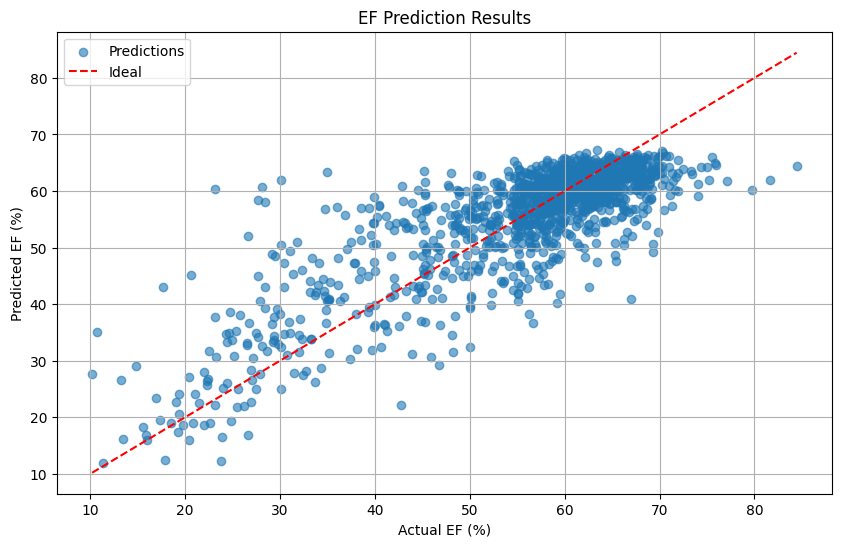

In [ ]:
evaluate_model('/content/FileList.csv', '/content/Videos', model_path='/content/best_ef_model.pth')


### **Complete Training**

In [ ]:
saved_model_path = train_model('/content/FileList.csv', '/content/Videos', num_epochs=50, batch_size=4)

Using device: cuda
Resuming from checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch25.pth
Starting Training...


Epoch 26/50 [Val]: 100%|██████████| 322/322 [00:54<00:00,  5.87it/s]


Epoch 26/50: Train Loss=77.4721, Val Loss=43.1471
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch26.pth
Saved new best model: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/best_ef_model.pth


Epoch 27/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  6.06it/s]


Epoch 27/50: Train Loss=77.9939, Val Loss=42.8319
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch27.pth
Saved new best model: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/best_ef_model.pth


Epoch 28/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.14it/s]


Epoch 28/50: Train Loss=74.0021, Val Loss=42.5617
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch28.pth
Saved new best model: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/best_ef_model.pth


Epoch 29/50 [Val]: 100%|██████████| 322/322 [00:52<00:00,  6.11it/s]


Epoch 29/50: Train Loss=75.6206, Val Loss=42.7739
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch29.pth


Epoch 30/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  5.98it/s]


Epoch 30/50: Train Loss=77.2848, Val Loss=42.9737
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch30.pth


Epoch 31/50 [Val]: 100%|██████████| 322/322 [00:54<00:00,  5.90it/s]


Epoch 31/50: Train Loss=73.8831, Val Loss=43.0812
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch31.pth


Epoch 32/50 [Val]: 100%|██████████| 322/322 [00:54<00:00,  5.87it/s]


Epoch 32/50: Train Loss=74.9872, Val Loss=43.1802
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch32.pth


Epoch 33/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  5.97it/s]


Epoch 33/50: Train Loss=74.3952, Val Loss=43.1095
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch33.pth


Epoch 34/50 [Train]:  82%|████████▏ | 1524/1867 [05:53<01:13,  4.65it/s, loss=24]  

Starting Evaluation...


Evaluating: 100%|██████████| 1277/1277 [01:12<00:00, 17.50it/s]


Test MAE: 5.14%
Test RMSE: 7.01%
Test R²: 0.6722


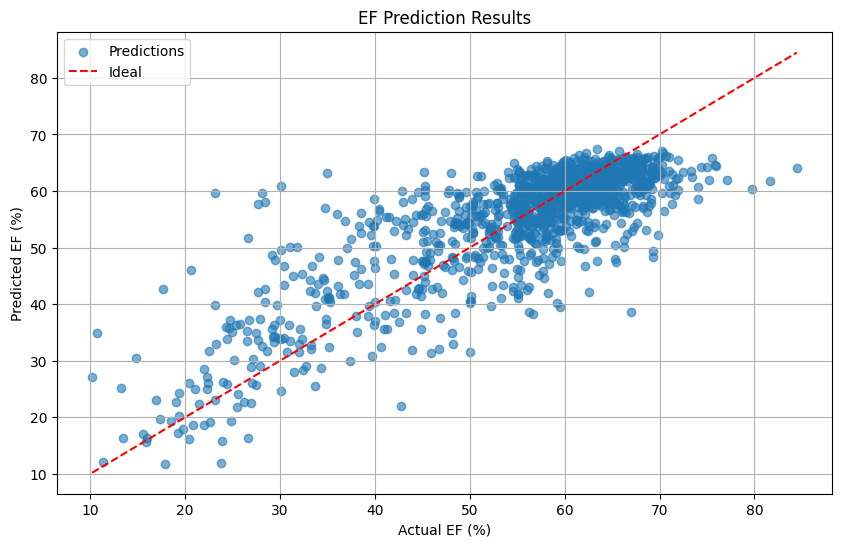

In [ ]:
evaluate_model('/content/FileList.csv', '/content/Videos', model_path='/content/checkpoints/best_ef_model.pth')


In [ ]:
saved_model_path = train_model('/content/FileList.csv', '/content/Videos', num_epochs=50, batch_size=4)

Using device: cuda
Resuming from checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch33.pth
Starting Training...


Epoch 34/50 [Val]: 100%|██████████| 322/322 [01:09<00:00,  4.62it/s]


Epoch 34/50: Train Loss=77.0206, Val Loss=43.3358
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch34.pth


Epoch 35/50 [Val]: 100%|██████████| 322/322 [01:05<00:00,  4.88it/s]


Epoch 35/50: Train Loss=75.1605, Val Loss=43.0869
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch35.pth
Saved new best model: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/best_ef_model.pth


Epoch 36/50 [Val]: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]


Epoch 36/50: Train Loss=74.5321, Val Loss=42.7528
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch36.pth
Saved new best model: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/best_ef_model.pth


Epoch 37/50 [Val]: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]


Epoch 37/50: Train Loss=78.1130, Val Loss=42.8750
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch37.pth


Epoch 38/50 [Val]: 100%|██████████| 322/322 [00:58<00:00,  5.48it/s]


Epoch 38/50: Train Loss=75.2555, Val Loss=42.9596
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch38.pth


Epoch 39/50 [Val]: 100%|██████████| 322/322 [00:58<00:00,  5.51it/s]


Epoch 39/50: Train Loss=77.1938, Val Loss=42.9206
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch39.pth


Epoch 40/50 [Val]: 100%|██████████| 322/322 [00:58<00:00,  5.54it/s]


Epoch 40/50: Train Loss=73.8200, Val Loss=42.8475
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch40.pth


Epoch 41/50 [Val]: 100%|██████████| 322/322 [00:58<00:00,  5.51it/s]


Epoch 41/50: Train Loss=77.2847, Val Loss=43.4577
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch41.pth


Epoch 42/50 [Val]: 100%|██████████| 322/322 [00:56<00:00,  5.72it/s]


Epoch 42/50: Train Loss=76.0994, Val Loss=43.0232
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch42.pth


Epoch 43/50 [Val]: 100%|██████████| 322/322 [00:55<00:00,  5.75it/s]


Epoch 43/50: Train Loss=75.0997, Val Loss=43.0310
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch43.pth


Epoch 44/50 [Val]: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]


Epoch 44/50: Train Loss=74.1779, Val Loss=42.8028
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch44.pth


Epoch 45/50 [Val]: 100%|██████████| 322/322 [01:03<00:00,  5.05it/s]


Epoch 45/50: Train Loss=75.2622, Val Loss=42.8822
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch45.pth


Epoch 46/50 [Train]:  52%|█████▏    | 971/1867 [04:12<03:59,  3.74it/s, loss=88.9]

Starting Evaluation...


Evaluating: 100%|██████████| 1277/1277 [09:20<00:00,  2.28it/s]


Test MAE: 5.16%
Test RMSE: 7.02%
Test R²: 0.6723


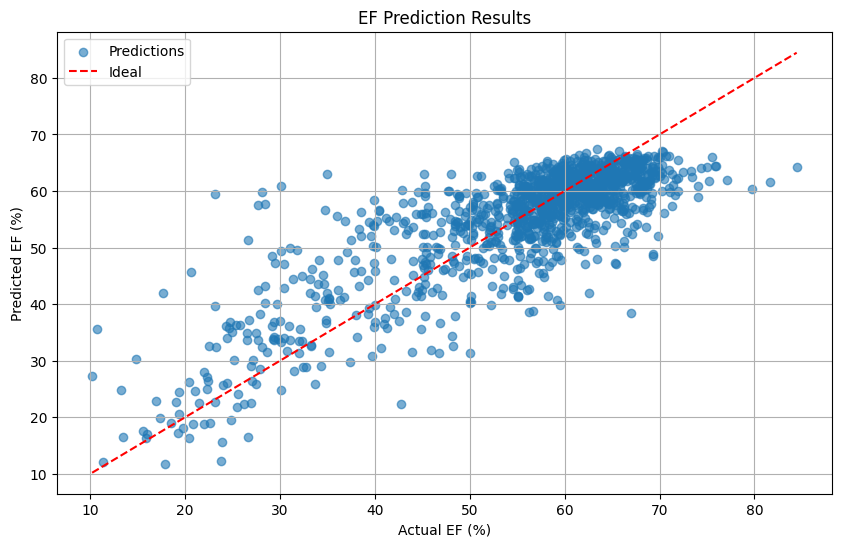

In [ ]:
evaluate_model('/content/FileList.csv', '/content/Videos', model_path='/content/checkpoints/best_ef_model.pth')


In [6]:
saved_model_path = train_model('/content/FileList.csv', '/content/Videos', num_epochs=50, batch_size=4)


Using device: cuda
Resuming from checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch45.pth
Starting Training...


Epoch 46/50 [Val]: 100%|██████████| 322/322 [01:00<00:00,  5.35it/s]


Epoch 46/50: Train Loss=75.1513, Val Loss=43.0295
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch46.pth


Epoch 47/50 [Val]: 100%|██████████| 322/322 [00:59<00:00,  5.44it/s]


Epoch 47/50: Train Loss=75.7339, Val Loss=42.9717
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch47.pth


Epoch 48/50 [Val]: 100%|██████████| 322/322 [00:55<00:00,  5.81it/s]


Epoch 48/50: Train Loss=75.8372, Val Loss=42.9598
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch48.pth


Epoch 49/50 [Val]: 100%|██████████| 322/322 [00:54<00:00,  5.95it/s]


Epoch 49/50: Train Loss=76.1499, Val Loss=42.9672
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch49.pth


Epoch 50/50 [Val]: 100%|██████████| 322/322 [00:53<00:00,  5.99it/s]

Epoch 50/50: Train Loss=75.8759, Val Loss=43.0854
Saved checkpoint: /content/drive/MyDrive/ECHO_NET_DYNAMIC/checkpoints/ef_model_epoch50.pth
Training Finished


Starting Evaluation...


Evaluating: 100%|██████████| 1277/1277 [01:01<00:00, 20.81it/s]


Test MAE: 5.16%
Test RMSE: 7.02%
Test R²: 0.6723


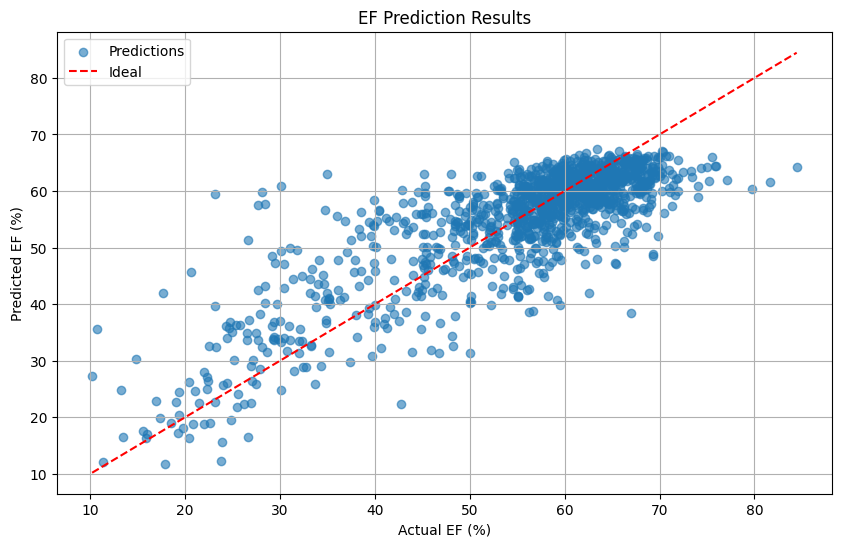

In [7]:
evaluate_model('/content/FileList.csv', '/content/Videos', model_path='/content/checkpoints/best_ef_model.pth')
